In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 16})
pd.set_option('display.max_columns', None)

## 1. Lectura de los datos desde un archivo Excel a un DataFrame en Pandas

In [15]:
dataDir='data'
resultsDir='results'

if not os.path.exists(resultsDir):
    os.mkdir(resultsDir)

In [16]:
dataFile='Base de Clientes.xlsx'
dataFile=os.path.join(dataDir, dataFile)

dataDF=pd.read_excel(dataFile, header=1, usecols='B:F')
dataDF.head()

,Clientes,Volumen Medio Anual,Precio Promedio por caja,Días de Retraso,Periodos con Compra promedio
0,1,15007.727667,18115.225772,45,6
1,2,27294.128556,14231.984602,40,10
2,3,18125.969000,16901.293994,10,10
3,4,14745.065333,19153.477426,15,11
4,5,11634.497778,17703.923246,60,11


In [17]:
print(len(dataDF))

149


['Clientes', 'Volumen Medio Anual', 'Precio Promedio por caja', 'Días de Retraso', 'Periodos con Compra promedio']
['Clientes', 'Volumen Medio Anual', 'Precio Promedio por caja', 'Días de Retraso', 'Periodos con Compra promedio']


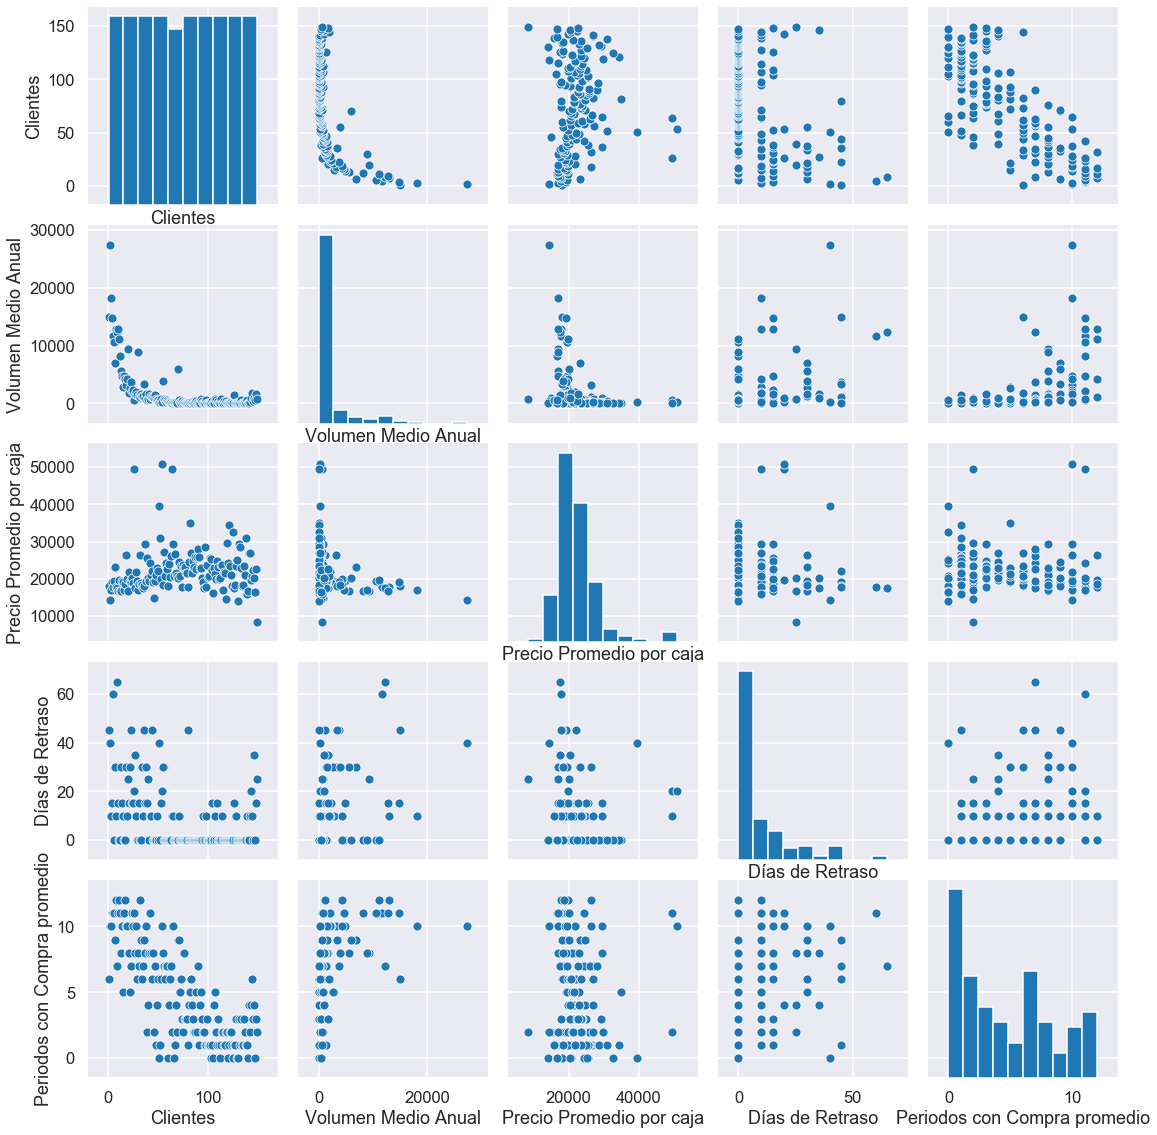

In [19]:
figFile = os.path.join(resultsDir, "scatter_plot_FCE.png")

sns.set_style('darkgrid')
sns.set_context("talk")#, rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":17}) 
g = sns.pairplot(dataDF)
#g.set_label_text()
#g = g.map(plt.scatter)

'''
for ax in g.axes.flat:
    # labelleft refers to yticklabels on the left side of each subplot
    ax.tick_params(axis='x', labelbottom=True)
    #ax.set_xlabel("Hola")
'''

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        #g.axes[j,i].yaxis.set_label_text(ylabels[j])

#g.set(ylabel='petal_width')
#_ = plt.setp(g.axes[0,1].get_yticklabels(), visible=True)
print(xlabels)
print(ylabels)

fig = g.fig 
fig.subplots_adjust(top=0.98, bottom=0.05, right=0.98, wspace=0.1, hspace=0.1)
g.fig.set_size_inches(16,16)
#plt.tight_layout()

plt.savefig(figFile)

## 2. Analisis de correlacion

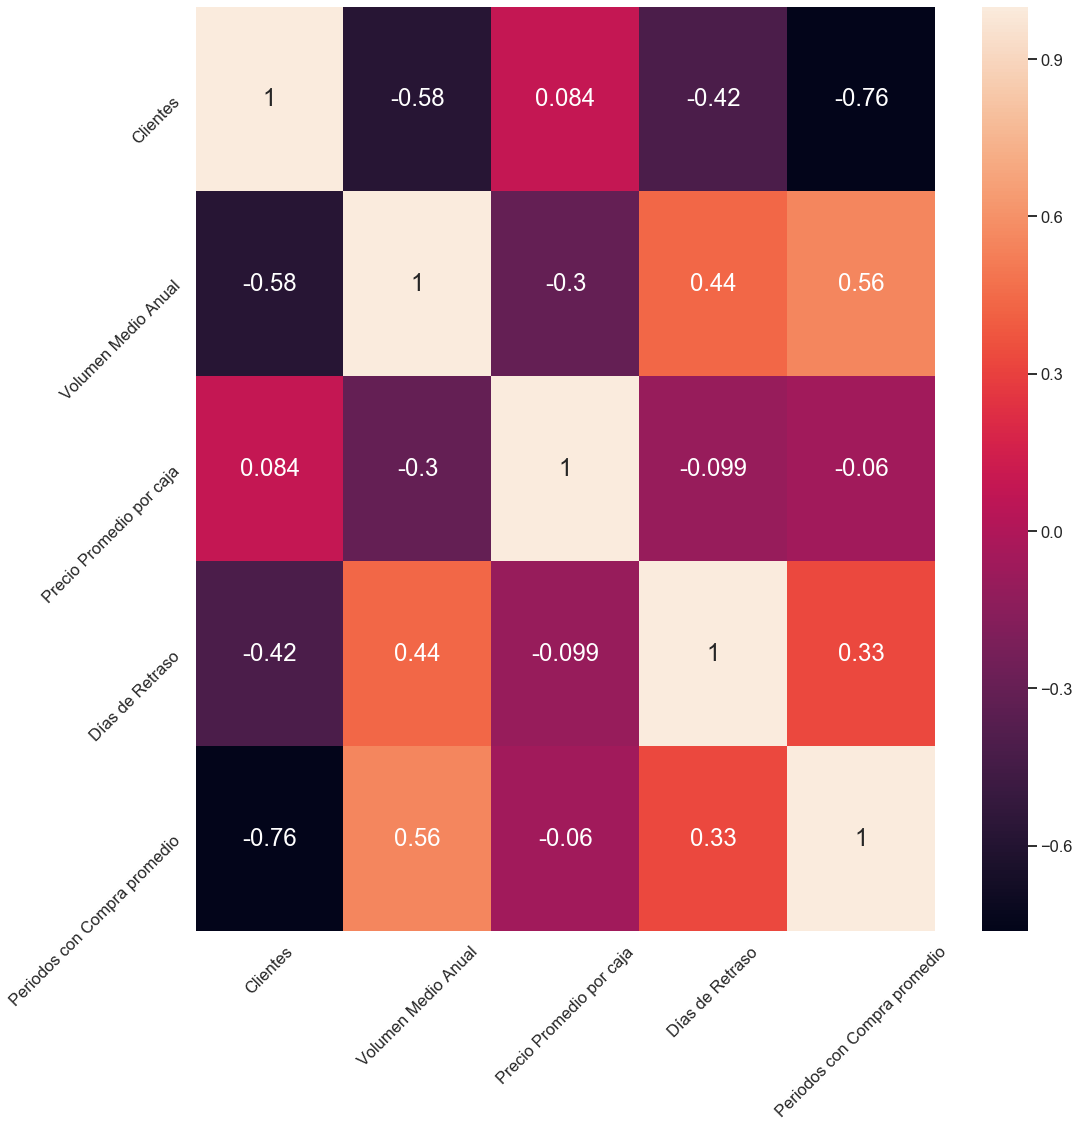

In [20]:
figFile = os.path.join(resultsDir, "correlation_plot_FCE.png")

fig, ax = plt.subplots(figsize=(16,16))
sns.set_context("talk", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":24}) 
g = sns.heatmap(dataDF.corr(), annot=True, annot_kws={"fontsize":24}, ax=ax)
#sns.set(font_scale=1)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
#g.set_size_inches(16,16)
plt.tight_layout()
plt.savefig(figFile)

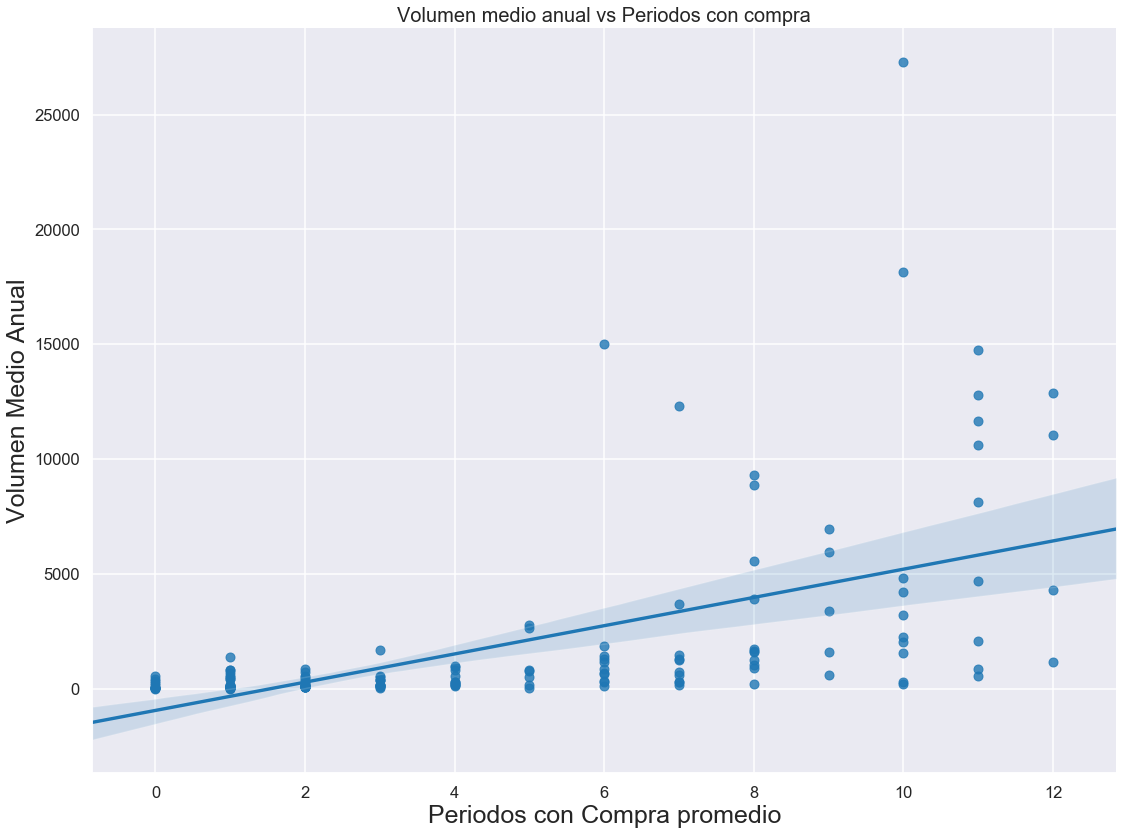

In [21]:
figFile = os.path.join(resultsDir, "regression_plot_FCE.png")

sns.set_context("talk", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":25}) 
g= sns.lmplot('Periodos con Compra promedio', 'Volumen Medio Anual', data=dataDF)
g.fig.set_size_inches(16,12)
plt.title('Volumen medio anual vs Periodos con compra')

plt.tight_layout()
plt.savefig(figFile)

## 3. Analisis de clustering usando metodo K-means

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

In [23]:
def plot_inertia(X):

  sse={}
  for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    sse[k] = kmeans.inertia_ 

  plt.figure()
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.show()

In [24]:
def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

In [25]:
dataDF.columns

Index(['Clientes', 'Volumen Medio Anual', 'Precio Promedio por caja',
       'Días de Retraso', 'Periodos con Compra promedio'],
      dtype='object')

In [26]:
maskColumns = [1,2,3,4]
X = dataDF.iloc[:, maskColumns]

# We standarize the features using a Normal distribution
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

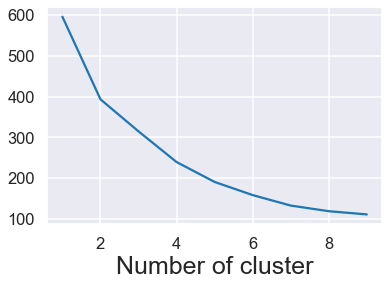

In [27]:
plot_inertia(X_std)

In [28]:
nClusters = 4
current_palette = sns.color_palette("tab10", n_colors=nClusters)

centers, labels = find_clusters(X_std, nClusters)
X['cluster'] = labels

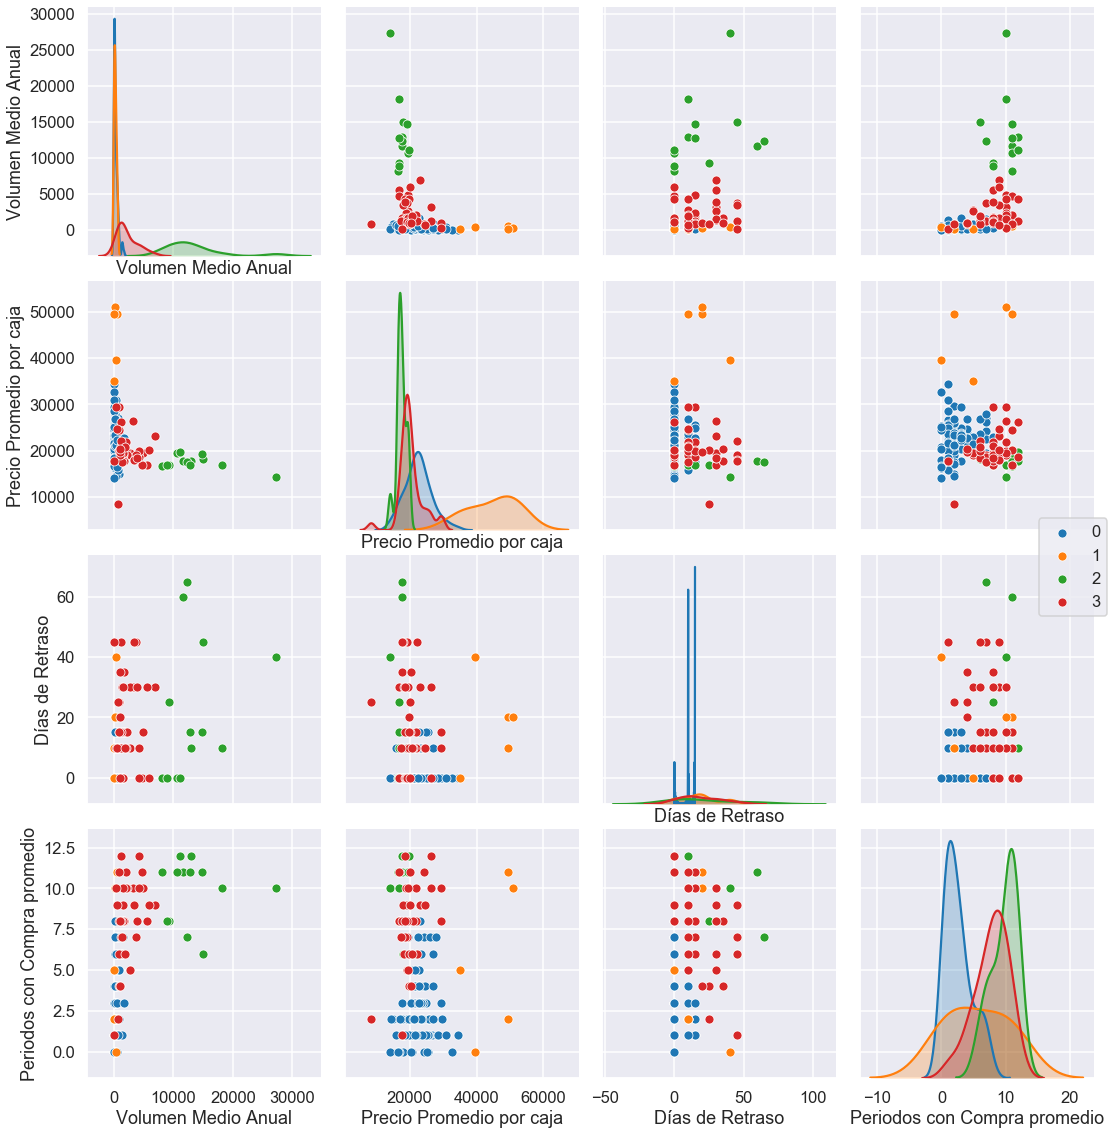

In [30]:
figFile = os.path.join(resultsDir, "clustering_plot_FCE.png")

sns.set_style('darkgrid')
sns.set_context("talk")
#sns.set_context("talk", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":17})

g = sns.pairplot(X, hue='cluster',  vars=['Volumen Medio Anual', 'Precio Promedio por caja',
       'Días de Retraso', 'Periodos con Compra promedio'],
       palette=current_palette, plot_kws={"alpha":1.0})

g._legend.remove()
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center right', ncol=1, frameon=True)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].xaxis.set_label_text(xlabels[i])

#g._legend.
#plt.legend(framealpha=1.)
#plt.legend(loc='upper right', title='Wine Type')
'''
for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50] 
'''

fig = g.fig 
fig.subplots_adjust(top=0.98, bottom=0.05, right=0.98, wspace=0.1, hspace=0.1)

g.fig.set_size_inches(16,16)
#plt.tight_layout()
plt.savefig(figFile)


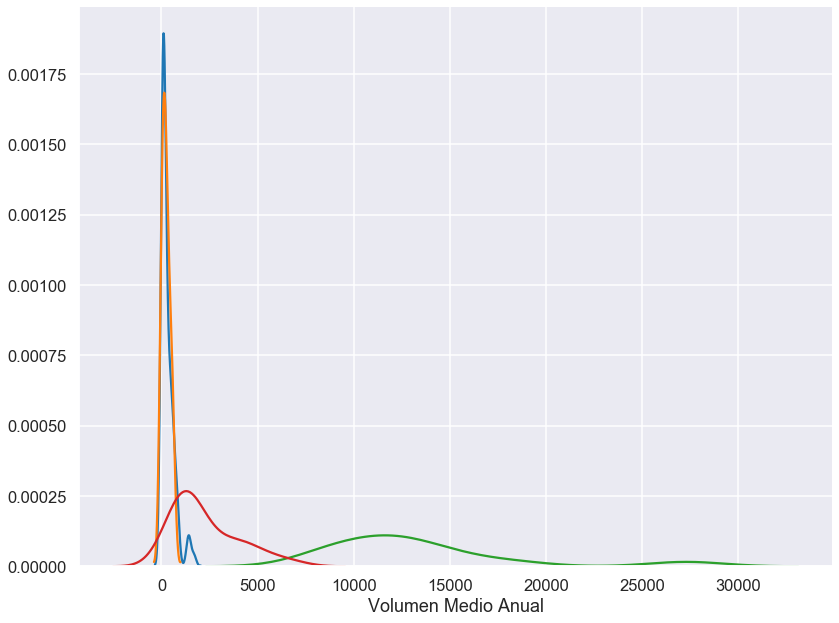

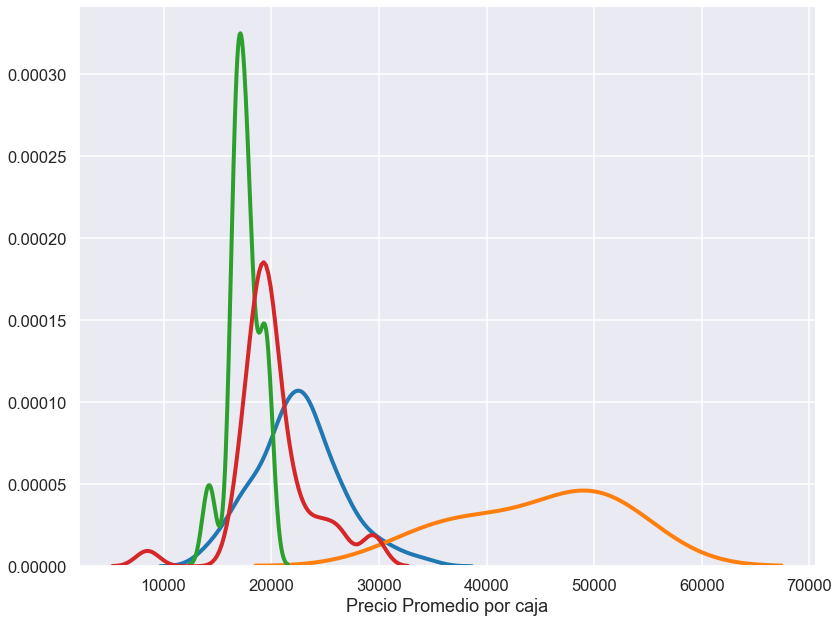

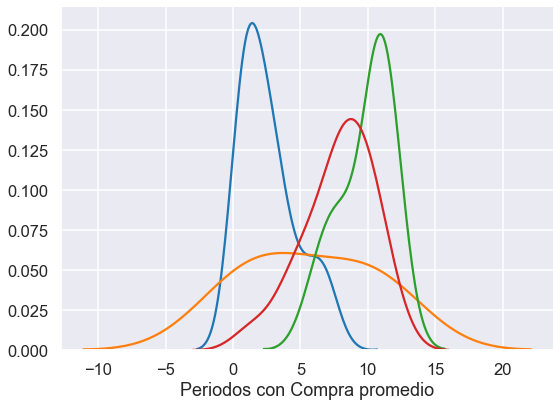

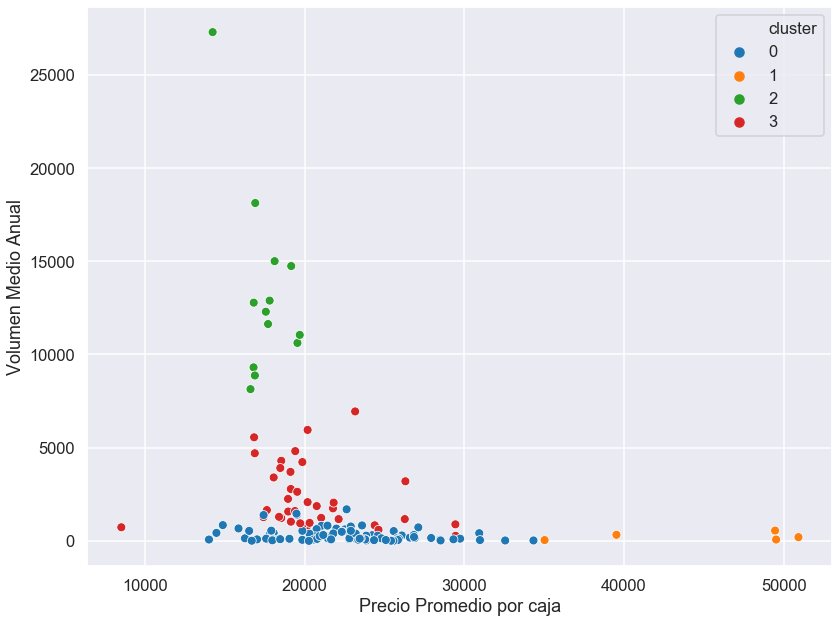

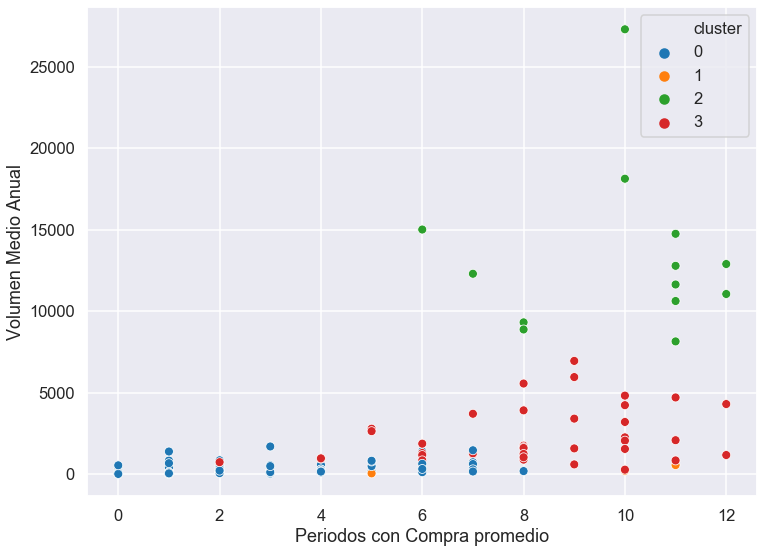

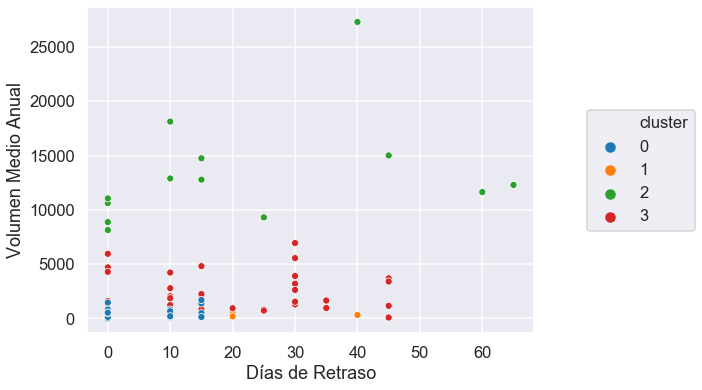

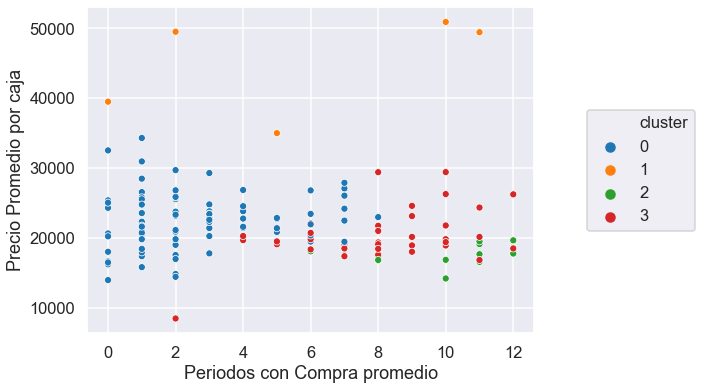

In [31]:
sns.set_style('darkgrid')
sns.set_context("talk")

g = sns.FacetGrid(X, hue="cluster")
g.fig.set_size_inches(12,9)
g = g.map(sns.kdeplot, "Volumen Medio Anual")
plt.tight_layout()
plt.show()

g = sns.FacetGrid(X, hue="cluster")
g.fig.set_size_inches(12,9)
g = g.map(sns.kdeplot, "Precio Promedio por caja", linewidth=4)
plt.tight_layout()
figFile = os.path.join(resultsDir, "histogram_precio_promedio_caja.png")
plt.savefig(figFile)
plt.show()

g = sns.FacetGrid(X, hue="cluster")
g.fig.set_size_inches(8,6)
g = g.map(sns.kdeplot, "Periodos con Compra promedio")
plt.show()

fig, ax = plt.subplots(figsize=(12,9))
g=sns.scatterplot( 'Precio Promedio por caja', 'Volumen Medio Anual', data=X,
                hue='cluster', s=80, palette=current_palette, ax=ax)
#g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.tight_layout()
figFile = os.path.join(resultsDir, "scatter_precio_promedio_volumen_medio.png")
plt.savefig(figFile)
plt.show()

fig, ax = plt.subplots(figsize=(12,9))
g=sns.scatterplot( 'Periodos con Compra promedio',  'Volumen Medio Anual', data=X,
                hue='cluster', s=80, palette=current_palette, ax=ax)
#g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
figFile = os.path.join(resultsDir, "scatter_periodos_compra_volumen_medio.png")
plt.savefig(figFile)
plt.show()


fig, ax = plt.subplots(figsize=(8,6))
g=sns.scatterplot( 'Días de Retraso', 'Volumen Medio Anual', data=X,
                hue='cluster', s=50, palette=current_palette, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
g=sns.scatterplot('Periodos con Compra promedio', 'Precio Promedio por caja', data=X,
                hue='cluster', s=50, palette=current_palette, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
plt.show()

In [32]:
summaryList=[]
for name, group in X.groupby("cluster"):
    tempMean = group.mean()
    tempDict = {"Segmento": name, "N clientes":len(group),
              "Venta promedio por cliente": np.round(tempMean['Volumen Medio Anual']*tempMean['Precio Promedio por caja'])/len(group),
              "Periodos con compra": tempMean['Periodos con Compra promedio'],
              "Precio promedio por caja": tempMean['Precio Promedio por caja'],
              "Volumen cajas promedio": tempMean['Volumen Medio Anual'],
              "Ventas anuales":np.round(tempMean['Volumen Medio Anual']*tempMean['Precio Promedio por caja']) }
    summaryList.append(tempDict)

    print("\nGroup name: ", name)
    print("Numero de clientes: ", len(group))
    print(group.mean())

summaryDF = pd.DataFrame(summaryList)
print(summaryDF)



Group name:  0
Numero de clientes:  92
Volumen Medio Anual               311.587165
Precio Promedio por caja        22539.985260
Días de Retraso                     1.684783
Periodos con Compra promedio        2.608696
cluster                             0.000000
dtype: float64

Group name:  1
Numero de clientes:  5
Volumen Medio Anual               240.177978
Precio Promedio por caja        44894.104163
Días de Retraso                    18.000000
Periodos con Compra promedio        5.600000
cluster                             1.000000
dtype: float64

Group name:  2
Numero de clientes:  13
Volumen Medio Anual             13290.256778
Precio Promedio por caja        17522.289688
Días de Retraso                    21.923077
Periodos con Compra promedio        9.846154
cluster                             2.000000
dtype: float64

Group name:  3
Numero de clientes:  39
Volumen Medio Anual              2254.291326
Precio Promedio por caja        20291.156262
Días de Retraso                

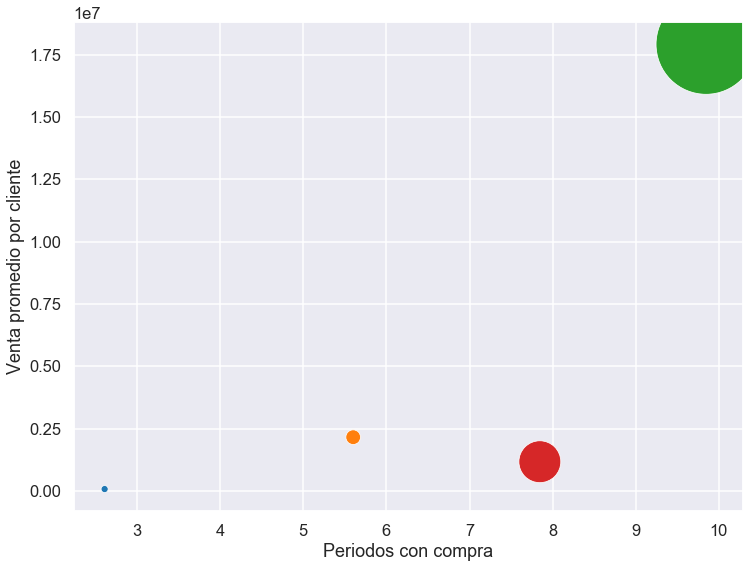

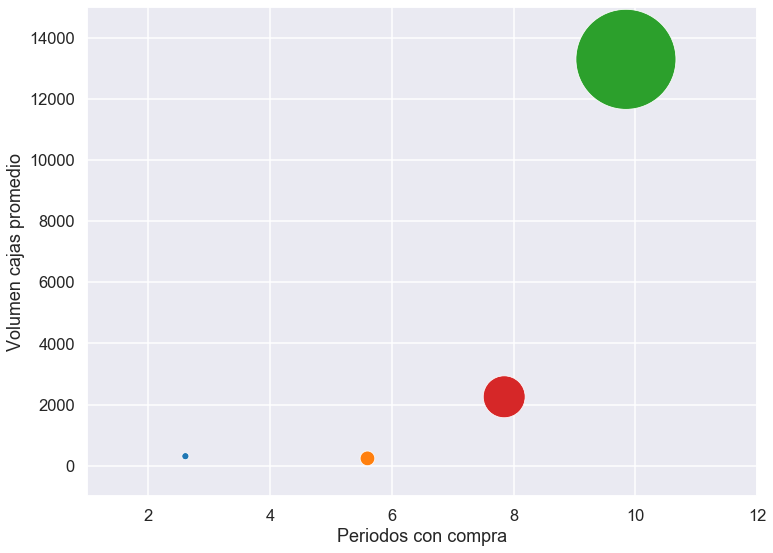

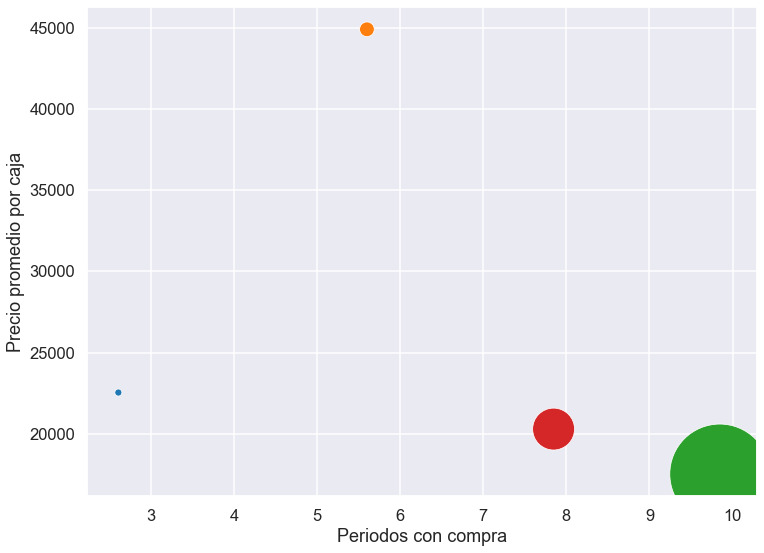

In [33]:
fig, ax = plt.subplots(figsize=(12,9))

sp = sns.scatterplot(x="Periodos con compra", y="Venta promedio por cliente", data=summaryDF, hue='Segmento',
                     size="Ventas anuales", sizes=(50, 10000), palette=current_palette, legend=None)

fig, ax = plt.subplots(figsize=(12,9))
sp = sns.scatterplot(x="Periodos con compra", y="Volumen cajas promedio", data=summaryDF, hue='Segmento',
                     size="Ventas anuales", sizes=(50, 10000), palette=current_palette, legend=None)
plt.xlim((1,12))
plt.ylim((-1e3,15e3))

fig, ax = plt.subplots(figsize=(12,9))
sp = sns.scatterplot(x="Periodos con compra", y="Precio promedio por caja", data=summaryDF, hue='Segmento',
                     size="Ventas anuales", sizes=(50, 10000), palette=current_palette, legend=None)


#sp._legend.remove()